<a href="https://colab.research.google.com/github/abhisheknad/PROJECT-CLUSTER/blob/main/Project_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering U.S. Communities Based on Energy Consumption Patterns Using Machine Learning**

ABHISHEK N A D (D22)

nadabhishek@gmail.com

**AIM**

To analyze and identify patterns in energy consumption across various communities using clustering techniques, thereby assisting stakeholders in optimizing energy management and decision-making.

**OBJECTIVES**

Data Preparation:

 Clean and preprocess the dataset, including handling missing values, encoding categorical variables, and standardizing numerical features to ensure accurate clustering.

Dimensionality Reduction:

 Use Principal Component Analysis (PCA) to reduce the complexity of the data while retaining significant variance for clustering.

Clustering Analysis:

 Implement KMeans clustering to group communities based on their energy consumption and other characteristics, identifying patterns and trends.

Outlier Detection:

Detect and remove outliers to improve the quality and interpretability of clustering results.

Cluster Evaluation:

Evaluate clustering performance using metrics such as the Davies-Bouldin Score and visualizations to validate the quality of clusters.

Geographical Insights:

 Map the clusters using geographical coordinates (latitude and longitude) to provide spatial insights into energy consumption behaviors.

[DATA SET](https://drive.google.com/file/d/1cMDT9X761Lw8mhRXw8FcWF_E0ba1zemZ/view?usp=drive_link)


LOADING LIBRARIES

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import scipy.stats as stat
import pylab
from sklearn.preprocessing import LabelEncoder

LOADING DATA

In [ ]:
data=pd.read_csv(r"/content/drive/MyDrive/utility-energy-registry-monthly-community-energy-use-beginning-2016-1.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


BASIC EDA

In [ ]:
def BasicEda(data):
    print(f"First 5 Rows of dataframe is \n{data.head()}")
    print("*******************************\n")
    print(f"List of columns in dataframe is {data.columns}")
    print("*******************************\n")
    print(f"The shape of dataframe is {data.shape}")
    print("*******************************\n")
    print(f"Description about dataframe Numerical columns:\n{data.describe()}")
    print(f"Description about dataframe Categorical columns:\n {data.describe(include='O')}")
    print("*******************************\n")
    print(f"Information about the data types of the dataframe : \n{data.info()}")
    print("*******************************\n")
    print(f"Number of nullvalues in dataframe is \n{data.isnull().sum()}")
    print(f"The percentage of missing values in the dataframe is \n {(data.isnull().sum()/len(data))*100}")
    missingPer=(data.isnull().sum()/len(data))*100
    print(f"Columns with more than 30% missing value \n {missingPer[missingPer>30].keys().tolist()}")
    nanCol30perGer=missingPer[missingPer>30].keys().tolist()
    nanCol30perless = missingPer[(missingPer > 0 ) & ( missingPer <=30)].keys().tolist()
    for i in data.columns:
        print(f"The feature {i} with {data[i].nunique()} unique values")
    return nanCol30perGer,nanCol30perless
nanCol30perGerList,nanCol30perlessList= BasicEda(data)

First 5 Rows of dataframe is 
   year   data_class  month       value     com_name com_type  \
0  2017  electricity      8     804.812        Sodus  Village   
1  2016  natural_gas      5    -999.000        Sodus  Village   
2  2017  natural_gas      6    7039.000      Spencer  Village   
3  2019  electricity      6     753.996        Sodus  Village   
4  2017  natural_gas     10  335498.000  Southampton  Village   

        data_field com_county  geometry_id  full_fips    unit  uer_id  \
0    all_other_(o)      Wayne      3668209    3668209     MWh       9   
1    all_other_(o)      Wayne      3668209    3668209  Therms       9   
2  residential_(r)      Tioga      3670167    3670167  Therms       6   
3    all_other_(o)      Wayne      3668209    3668209     MWh       6   
4        total_(t)    Suffolk      3668462    3668462  Therms       5   

         data_stream utility_display_name  number_of_accounts  \
0  community_monthly                 RG&E                37.0   
1  communi

Inference from the Dataset Overview

1)Dataset Size and Structure:

The dataset consists of 867,266 records and 16 features. It includes both numerical and categorical columns, reflecting diverse aspects of community energy usage.

2)Numerical Data:

Key numerical features include year, month, value (energy consumption), geometry_id, full_fips, uer_id, and number_of_accounts.
The value column, representing energy consumption, varies widely, with a minimum of -117,036 (possibly indicating missing or invalid data) and a maximum of 43,378,040. This suggests that there is significant variation in energy use between communities.
The number_of_accounts column also shows a wide range (0 to 120,516 accounts), but 18.56% of its values are missing, indicating potential data quality issues.

3)Categorical Data:

The dataset has a good variety of categorical features, such as data_class, com_name, com_type, data_field, and utility_display_name. For example, the data_class column indicates whether the record pertains to electricity or natural gas, while com_type differentiates between types of communities (e.g., villages, towns, etc.).
The com_name and com_county columns capture location-specific information, with 1,278 unique community names and 61 unique counties represented.
The Georeference feature provides detailed geographical coordinates for communities, allowing for spatial analysis.

4)Missing Data:

The com_county column has 2.32% missing values, which may be negligible, depending on the analysis.
The number_of_accounts column has a more significant proportion of missing data (18.56%), which may require imputation or other handling methods during analysis.

5)Unique Values:

The dataset shows a variety of distinct values across different columns. For instance, the value column has 301,112 unique values, indicating a large variability in energy consumption.
Some columns, such as data_stream, have a single unique value ("community_monthly"), which may not add much variability to the analysis.
The Georeference column, with 1,205 unique coordinates, suggests that a significant number of communities share the same geographic location.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer



# Step 1: Extract Latitude and Longitude
data[['longitude', 'latitude']] = data['Georeference'].str.extract(r'POINT \(([-\d.]+) ([-\d.]+)\)').astype(float)

# Step 2: Handle Missing Values
# Impute missing 'com_county' with the mode (most frequent category)
data['com_county'].fillna(data['com_county'].mode()[0], inplace=True)

# Impute missing 'number_of_accounts' with the median (handling skewed data)
data['number_of_accounts'].fillna(data['number_of_accounts'].median(), inplace=True)
# Step 3: Encode Categorical Features
# Frequency encoding for high-cardinality features
freq_encoding = data['com_name'].value_counts(normalize=True).to_dict()
data['com_name_freq'] = data['com_name'].map(freq_encoding)

freq_encoding_county = data['com_county'].value_counts(normalize=True).to_dict()
data['com_county_freq'] = data['com_county'].map(freq_encoding_county)

# Label encode or one-hot encode low-cardinality features
label_encoder = LabelEncoder()
low_cardinality_features = ['data_class', 'com_type', 'data_field', 'unit', 'utility_display_name']

for col in low_cardinality_features:
    data[col] = label_encoder.fit_transform(data[col])

# Step 4: Drop Irrelevant Columns
data = data.drop(columns=['Georeference', 'data_stream', 'com_name', 'com_county', 'full_fips'])

# Step 5: Standardize Numerical Features
scaler = StandardScaler()
numerical_features = ['value', 'number_of_accounts', 'geometry_id']
data[numerical_features] = scaler.fit_transform(data[numerical_features])




<ipython-input-6-f7960db1124c>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['com_county'].fillna(data['com_county'].mode()[0], inplace=True)
<ipython-input-6-f7960db1124c>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [ ]:
# Calculate Q1, Q3, and IQR
Q1 =data['value'].quantile(0.25)
Q3 = data['value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data = data[(data['value'] >= lower_bound) & (data['value'] <= upper_bound)]

# Check the shape of the data after removing outliers
print(f"Shape of dataset after outlier removal: {data.shape}")

Shape of dataset after outlier removal: (711401, 15)


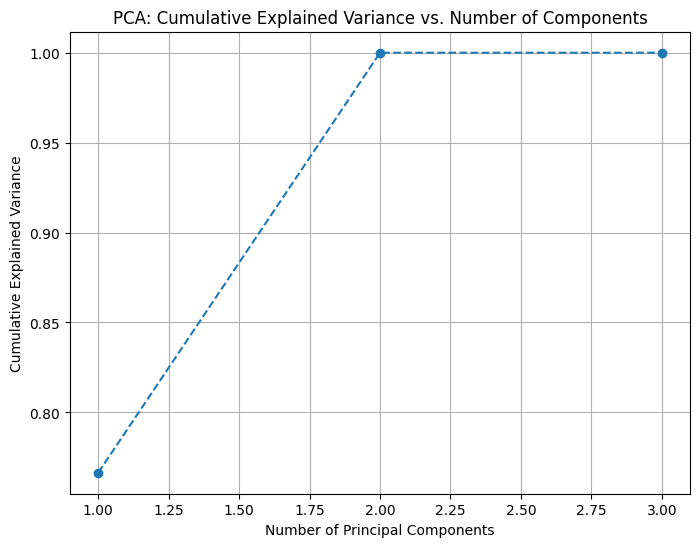

Number of components that explain at least 95% variance: 2


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Perform PCA on the numerical features
pca = PCA()
pca.fit(data[numerical_features])

# Step 2: Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Step 3: Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Step 4: Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Step 5: Determine the number of components that explain 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components that explain at least 95% variance: {n_components_95}")


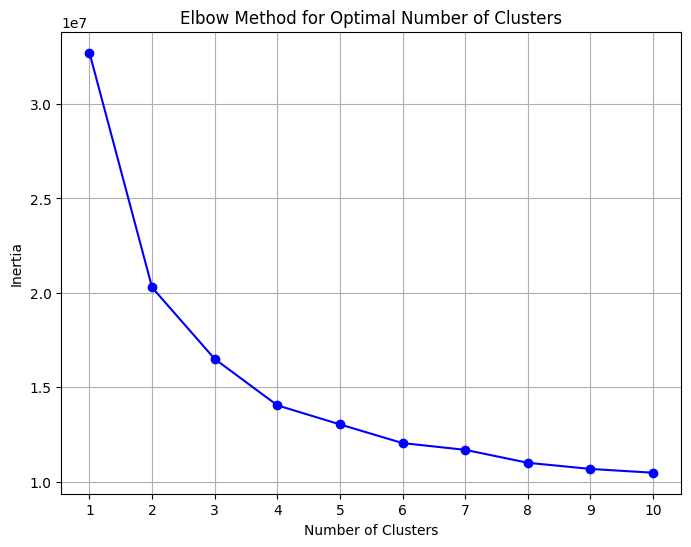

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Prepare the features for K-means (we'll use PCA-transformed features)
# You can use the PCA-transformed features you already have
X = data  # Assuming pca_features is the PCA-transformed data

# Step 2: Calculate inertia for a range of cluster numbers
inertia = []
for k in range(1, 11):  # Test cluster sizes from 1 to 10
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


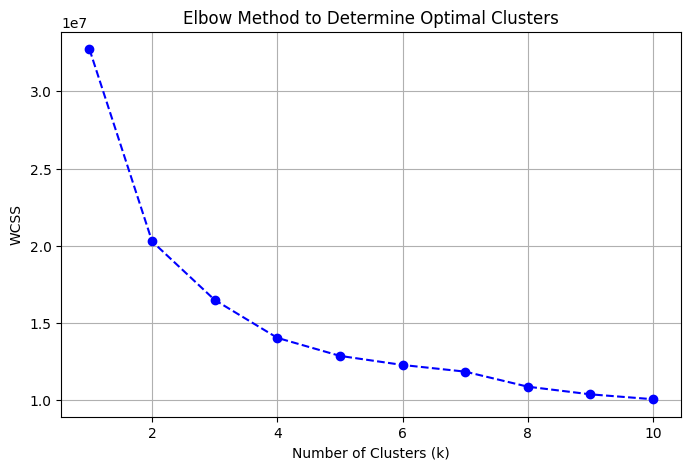

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

# Assuming `data` is your preprocessed DataFrame
# Ensure data is numeric and scaled (e.g., using StandardScaler)

# Step 1: Calculate WCSS for different values of k
wcss = []
max_clusters = 10  # Set the range for the number of clusters
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(data)  # Replace `data` with your dataset
    wcss.append(kmeans.inertia_)  # WCSS is stored in `inertia_`

# Step 2: Plot the Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


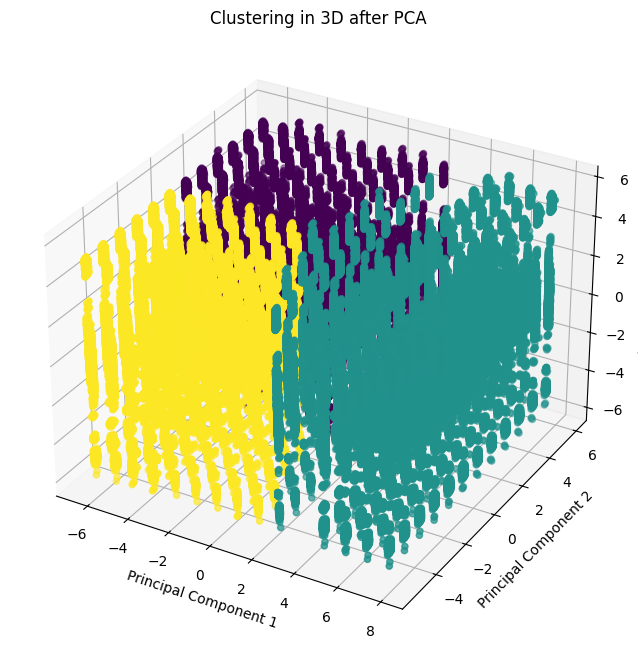

Cluster Centers:  [[-3.24926809e+00  3.38368751e+00  3.39217246e-02]
 [ 5.08193180e+00 -9.12120791e-02 -2.28000587e-02]
 [-3.44593949e+00 -2.80078101e+00 -1.19192897e-03]]
Cluster Labels:  [0 2 1]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
pca_features = pca.fit_transform(data)

# Step 2: Apply KMeans clustering (assuming we want 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(pca_features)

# Step 3: Visualize the clustering in 3D (optional but useful)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], c=data['Cluster'], cmap='viridis', s=20)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Clustering in 3D after PCA')
plt.show()

# Step 4: Analyze the clusters
print("Cluster Centers: ", kmeans.cluster_centers_)
print("Cluster Labels: ", data['Cluster'].unique())


In [ ]:
from sklearn.metrics import  davies_bouldin_score

# Step 2: Compute Davies-Bouldin Score
db_score = davies_bouldin_score(pca_features, data['Cluster'])
print(f"Davies-Bouldin Score: {db_score:.4f}")


Davies-Bouldin Score: 0.9752


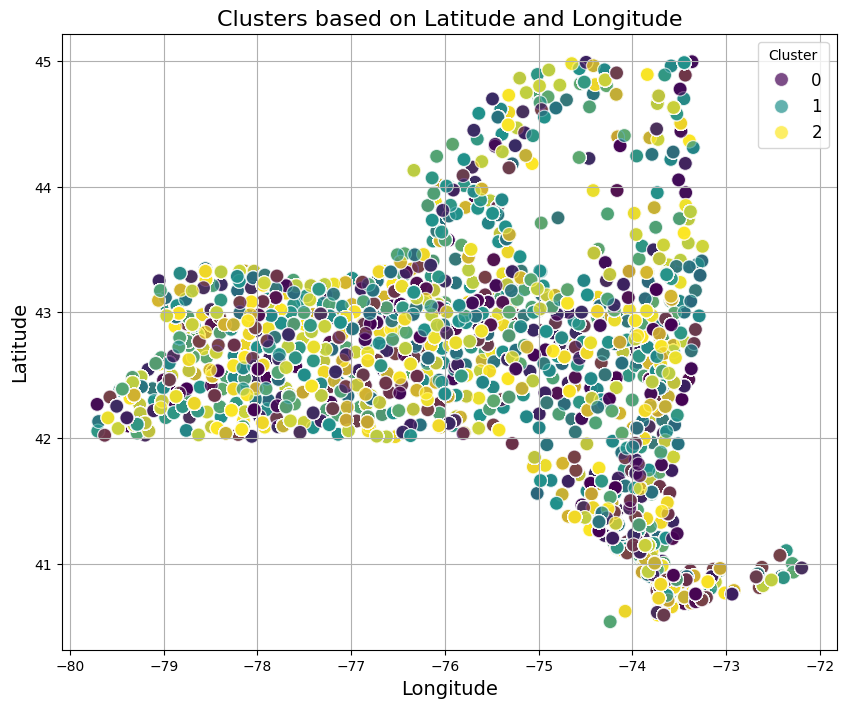

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your dataset contains the following columns: latitude, longitude, and Cluster
# Example: `data` is the DataFrame with cluster labels

# Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='Cluster',  # Color points based on their cluster
    data=data,      # Your DataFrame
    palette='viridis',  # Choose a colormap
    alpha=0.7,  # Set transparency
    s=100       # Set marker size
)

# Add plot title and labels
plt.title('Clusters based on Latitude and Longitude', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)
plt.show()


<ipython-input-13-d55562dc4a59>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['com_county'].fillna(data['com_county'].mode()[0], inplace=True)
<ipython-input-13-d55562dc4a59>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

Davies-Bouldin Score: 0.8527


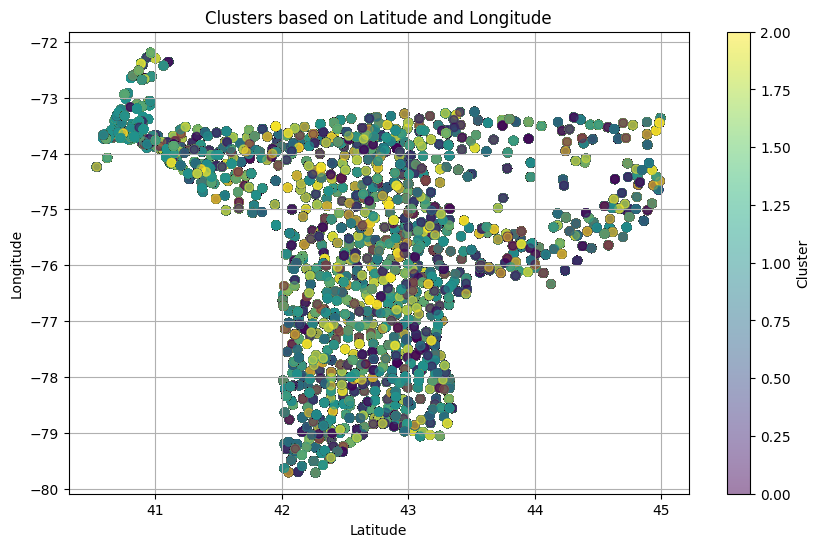

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Step 1: Load and Preprocess the Data
data=pd.read_csv(r"/content/drive/MyDrive/utility-energy-registry-monthly-community-energy-use-beginning-2016-1.csv")
# Assuming 'data' is the DataFrame you already loaded
# Extract Latitude and Longitude from 'Georeference'
data[['longitude', 'latitude']] = data['Georeference'].str.extract(r'POINT \(([-\d.]+) ([-\d.]+)\)').astype(float)

# Impute missing values
data['com_county'].fillna(data['com_county'].mode()[0], inplace=True)
data['number_of_accounts'].fillna(data['number_of_accounts'].median(), inplace=True)

# Encode categorical features using Label Encoding for low-cardinality columns and Frequency Encoding for high-cardinality columns
low_cardinality_features = ['data_class', 'com_type', 'data_field', 'unit', 'utility_display_name']
label_encoder = LabelEncoder()
for col in low_cardinality_features:
    data[col] = label_encoder.fit_transform(data[col])

# Frequency encoding for high-cardinality features
freq_encoding = data['com_name'].value_counts(normalize=True).to_dict()
data['com_name_freq'] = data['com_name'].map(freq_encoding)

freq_encoding_county = data['com_county'].value_counts(normalize=True).to_dict()
data['com_county_freq'] = data['com_county'].map(freq_encoding_county)

# Drop irrelevant columns for clustering
data = data.drop(columns=['Georeference', 'data_stream', 'com_name', 'com_county', 'full_fips'])
scaler = StandardScaler()
numerical_features = ['value', 'number_of_accounts', 'geometry_id']
data[numerical_features] = scaler.fit_transform(data[numerical_features])
# Calculate Q1, Q3, and IQR
Q1 =data['value'].quantile(0.25)
Q3 = data['value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data = data[(data['value'] >= lower_bound) & (data['value'] <= upper_bound)]



# Step 2: PCA for Dimensionality Reduction
pca = PCA(n_components=2)  # Use 2 components based on previous analysis
pca_features = pca.fit_transform(data)

# Step 3: Clustering using KMeans
kmeans = KMeans(n_clusters=3)  # Choose an optimal number of clusters (example: 3)
data['Cluster'] = kmeans.fit_predict(pca_features)

# Step 4: Calculate Clustering Metrics

db_score = davies_bouldin_score(pca_features, data['Cluster'])

print(f"Davies-Bouldin Score: {db_score:.4f}")

# Step 5: Plot the Clusters Based on Latitude and Longitude
plt.figure(figsize=(10, 6))
plt.scatter(data['latitude'], data['longitude'], c=data['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clusters based on Latitude and Longitude')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


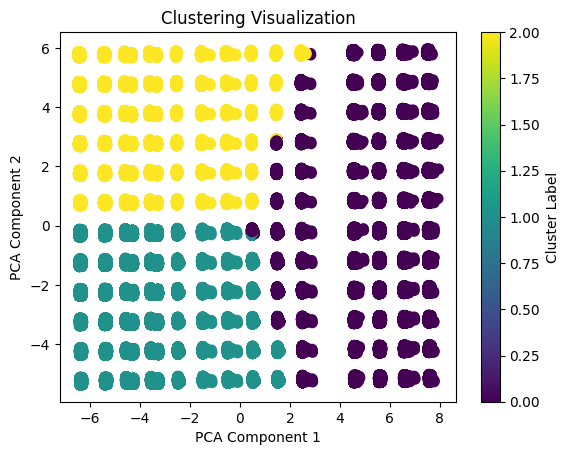

In [ ]:
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=data['Cluster'], cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering Visualization')
plt.show()


In [ ]:
cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)


                year  data_class     month     value  com_type  data_field  \
Cluster                                                                      
0        2017.129716    0.315826  6.069471 -0.096609  2.245524   11.548911   
1        2017.231220    0.306769  3.428970 -0.096812  2.229908    3.038641   
2        2016.901079    0.311531  9.593257 -0.096799  2.236516    3.280971   

         geometry_id      unit    uer_id  utility_display_name  \
Cluster                                                          
0           0.019932  2.093603  5.348187              2.949280   
1           0.018432  1.245545  5.364554              2.971073   
2           0.008584  1.187792  5.449724              2.883388   

         number_of_accounts  longitude   latitude  com_name_freq  \
Cluster                                                            
0                 -0.043856 -75.815154  42.650012       0.001030   
1                 -0.166082 -75.906549  42.627370       0.001044   
2     

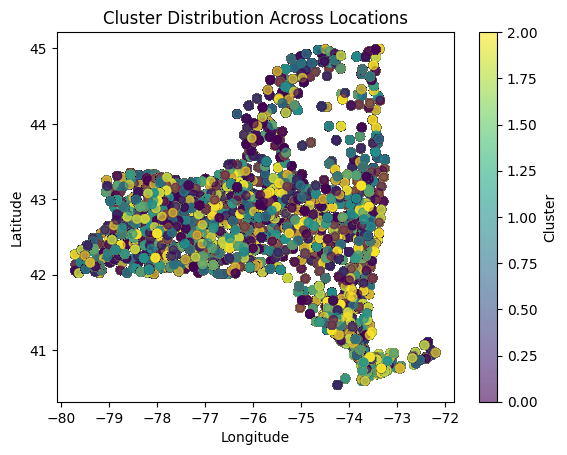

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

plt.scatter(data['longitude'], data['latitude'], c=data['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Distribution Across Locations')
plt.show()


In [ ]:
print(data['Cluster'].value_counts())


Cluster
0    281785
1    230923
2    198693
Name: count, dtype: int64


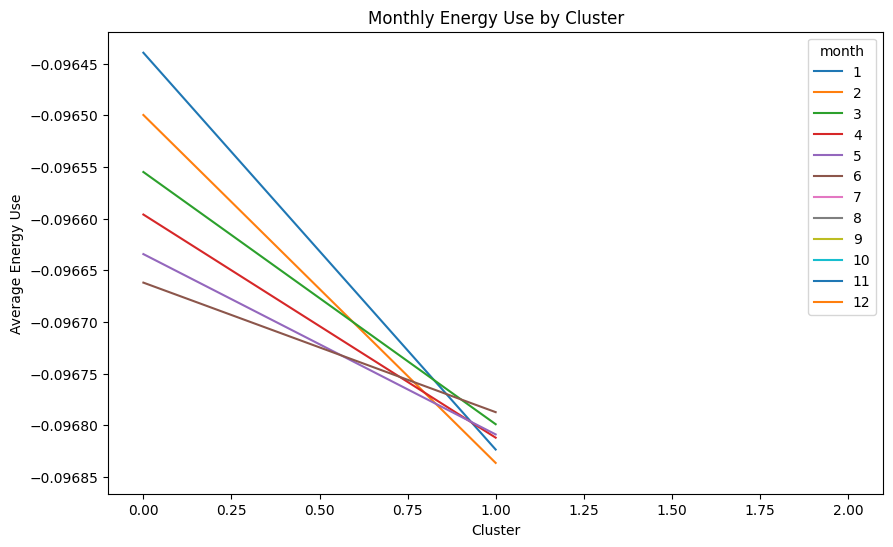

In [ ]:
cluster_time = data.groupby(['Cluster', 'month']).mean()['value'].unstack()
cluster_time.plot(kind='line', figsize=(10, 6), title='Monthly Energy Use by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Energy Use')
plt.show()


         (value, mean)  (value, median)  (number_of_accounts, mean)  \
Cluster                                                               
0            -0.096605        -0.097109                   -0.058406   
1            -0.096820        -0.097104                   -0.174787   
2            -0.096659        -0.097131                   -0.061494   

         (number_of_accounts, median)  (com_name_freq, mean)  \
Cluster                                                        
0                           -0.201593               0.001032   
1                           -0.217773               0.001037   
2                           -0.201593               0.001038   

         (com_county_freq, mean)  data_class  com_type  data_field  unit  \
Cluster                                                                    
0                       0.021258           0         2          12     2   
1                       0.022170           0         2           3     0   
2                  

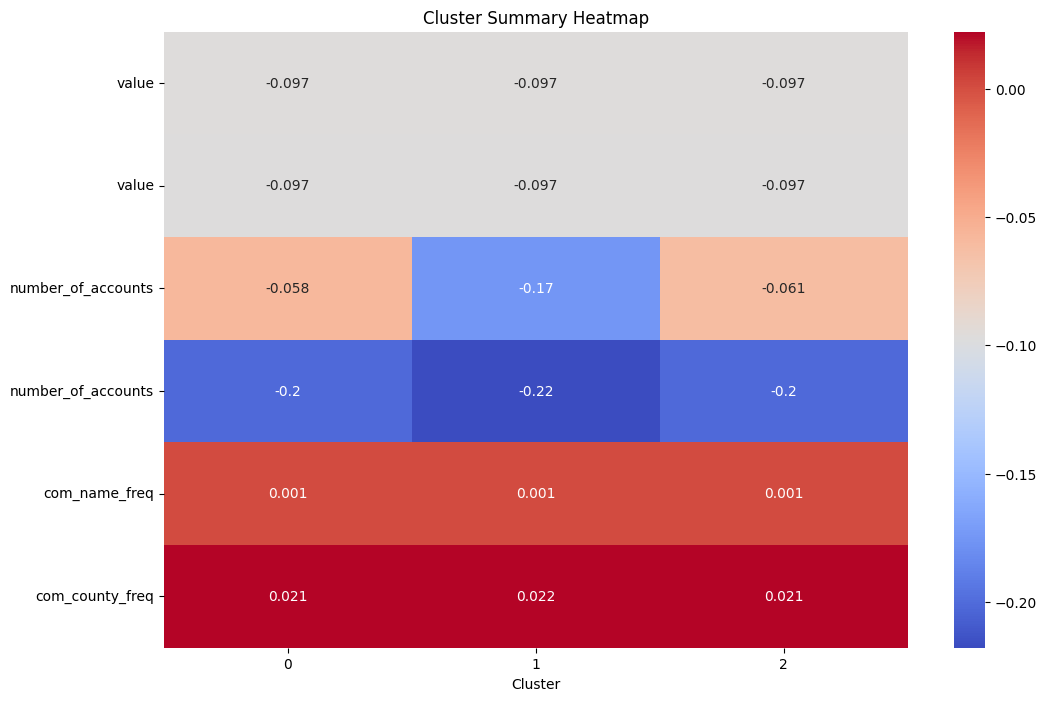

In [ ]:
# Add the cluster label back to the data
clustered_data = data.copy()

# Step 1: Calculate mean, median, and mode for each cluster
cluster_summary = clustered_data.groupby('Cluster').agg({
    'value': ['mean', 'median'],
    'number_of_accounts': ['mean', 'median'],
    'com_name_freq': 'mean',
    'com_county_freq': 'mean',
    # Add other numerical features if needed
})

# Step 2: Analyze categorical features (using mode)
categorical_features = ['data_class', 'com_type', 'data_field', 'unit', 'utility_display_name']
categorical_modes = clustered_data.groupby('Cluster')[categorical_features].agg(lambda x: x.mode()[0])

# Combine numerical and categorical summaries
cluster_analysis = pd.concat([cluster_summary, categorical_modes], axis=1)

# Display the cluster analysis
print(cluster_analysis)

# Optional visualization: Heatmap to highlight differences between clusters
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary.droplevel(level=1, axis=1).T, annot=True, cmap='coolwarm')
plt.title('Cluster Summary Heatmap')
plt.show()


In [ ]:
from joblib import dump, load

# Save the trained KMeans model
dump(kmeans, 'kmeans_model.joblib')


['kmeans_model.joblib']

In [ ]:
# Load the saved KMeans model
kmeans_loaded = load('kmeans_model.joblib')


In [ ]:
from joblib import dump

# Save PCA and Scaler models
dump(pca, 'pca_model.joblib')  # Save the PCA model
dump(scaler, 'scaler_model.joblib')  # Save the StandardScaler model


['scaler_model.joblib']

In [ ]:
pca_model = load('pca_model.joblib')  # Example if saved in the 'models' folder


In [ ]:
import numpy as np
from joblib import load

# Load saved models
kmeans_model = load('kmeans_model.joblib')  # Load the saved KMeans model
pca_model = load('pca_model.joblib')        # Load the saved PCA model
scaler = load('scaler_model.joblib')        # Load the saved StandardScaler model

# Provided unseen data (ensure it's in a DataFrame format for compatibility)
unseen_data = pd.DataFrame([{
    'year': 2018,
    'data_class': 0,
    'month': 10,
    'value': -0.097142,
    'com_type': 2,
    'data_field': 9,
    'geometry_id': 0.669565,
    'unit': 1,
    'uer_id': 2,
    'utility_display_name': 0,
    'number_of_accounts': -0.237324,
    'longitude': -74.219292,
    'latitude': 42.213719,
    'com_name_freq': 0.001965,
    'com_county_freq': 0.016251
}])

# Select numerical features used during training
numerical_features = ['value', 'number_of_accounts', 'geometry_id']

# Scale the numerical features
unseen_data[numerical_features] = scaler.transform(unseen_data[numerical_features])

# Apply PCA transformation
pca_features_unseen = pca_model.transform(unseen_data)

# Predict the cluster
predicted_cluster = kmeans_model.predict(pca_features_unseen)

print(f"Predicted Cluster: {predicted_cluster[0]}")


Predicted Cluster: 2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

# Load trained models
kmeans = load('kmeans_model.joblib')         # Pre-trained KMeans model
pca = load('pca_model.joblib')               # Pre-trained PCA model
scaler = load('scaler_model.joblib')         # Pre-trained StandardScaler model



# Step 1: Define the new unseen data
unseen_data = pd.DataFrame([{
    'year': 2017,
    'data_class': 1,
    'month': 3,
    'value': -0.097118,
    'com_type': 2,
    'data_field': 3,
    'geometry_id': 0.669424,
    'unit': 4,
    'uer_id': 4,
    'utility_display_name': 3,
    'number_of_accounts': -0.234177,
    'longitude': -78.256925,
    'latitude': 42.901295,
    'com_name_freq': 0.001263,
    'com_county_freq': 0.013398
}])



# Select numerical features used during training
numerical_features = ['value', 'number_of_accounts', 'geometry_id']

# Scale the numerical features
unseen_data[numerical_features] = scaler.transform(unseen_data[numerical_features])

# Apply PCA transformation
pca_features_unseen = pca_model.transform(unseen_data)

# Predict the cluster
predicted_cluster = kmeans_model.predict(pca_features_unseen)

print(f"Predicted Cluster: {predicted_cluster[0]}")


Predicted Cluster: 1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

# Load trained models
kmeans = load('kmeans_model.joblib')         # Pre-trained KMeans model
pca = load('pca_model.joblib')               # Pre-trained PCA model
scaler = load('scaler_model.joblib')         # Pre-trained StandardScaler model
unseen_data = pd.DataFrame([{
    'year': 2018,
    'data_class': 1,
    'month': 6,
    'value': -0.095386,
    'com_type': 2,
    'data_field': 13,
    'geometry_id': 0.669331,
    'unit': 3,
    'uer_id': 5,
    'utility_display_name': 4,
    'number_of_accounts': -0.232155,
    'longitude': -74.264686,
    'latitude': 43.104571,
    'com_name_freq': 0.000941,
    'com_county_freq': 0.007910
}])


# Select numerical features used during training
numerical_features = ['value', 'number_of_accounts', 'geometry_id']

# Scale the numerical features
unseen_data[numerical_features] = scaler.transform(unseen_data[numerical_features])

# Apply PCA transformation
pca_features_unseen = pca_model.transform(unseen_data)

# Predict the cluster
predicted_cluster = kmeans_model.predict(pca_features_unseen)

print(f"Predicted Cluster: {predicted_cluster[0]}")

Predicted Cluster: 0


**CONCLUSION**

The clustering analysis effectively grouped communities based on their energy consumption characteristics. By leveraging PCA for dimensionality reduction, the project retained essential data features while improving clustering efficiency. The use of the Davies-Bouldin Score indicated the quality of the clustering results, and geographical visualizations provided intuitive insights into spatial patterns of energy usage. These results can help energy providers and policymakers target specific clusters for resource optimization, energy conservation initiatives, and infrastructure planning.

**INFERENCE**

Community Segmentation:

Communities with similar energy consumption patterns were successfully grouped, revealing distinct clusters with shared characteristics.

Geospatial Trends:
 The spatial distribution of clusters suggests that geographical factors influence energy consumption, which may correlate with population density, climate, or economic activity.

Outliers:
 Removal of outliers significantly improved the clustering quality, demonstrating that extreme values can distort unsupervised learning models.

Policy Implications:

 The identified clusters can guide decision-making, such as prioritizing high-consumption areas for renewable energy deployment or efficiency programs.

Data Insights:

 The methodology established a reproducible framework for analyzing energy datasets and applying clustering techniques to other regions or domains.